# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Transaction variables**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**


# 1. Importation and memory reduction
## 1.1. Importing necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go

import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots

from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff


# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
import time

In [0]:
### Import data from google drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link1 = 'https://drive.google.com/open?id=1-2YM1zPLC6L4e94c7UHtfm70-UhrJAx9'
link2 = 'https://drive.google.com/open?id=1-8b83OZ7qoWypGqquhyXXmbETyhjDq0G'

link5 = 'https://drive.google.com/open?id=1v5in81M0aYl-pX5u-8Tq4G8kwFp4CVez'
_, id1 = link1.split('=')
_, id2 = link2.split('=')

_, id5 = link5.split('=')

downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('df_train.pkl')  
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('df_test.pkl')  

downloaded5 = drive.CreateFile({'id':id5}) 
downloaded5.GetContentFile('sample_submission.csv')

## 1.2. Importing train datasets

In [0]:
df_train = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
print(df_train.shape)
print(df_test.shape)

(590540, 430)
(506691, 429)


## 1.3. Memory reduction

In [0]:
def resumetable(df):
    n = df.shape[0]
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values  
    summary['Missing %'] = round(summary['Missing'] / n * 100,2)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values


    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True, object_tranform = False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    print('Lower bounded value: {:.2f}'.format(lower))
    print('Upper bounded value: {:.2f}'.format(upper))
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

To see the output of the Resume Table, click to see the output 

# 2. Preprocessing

In [7]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,dist1_na,dist2_na,_Weekdays,_Hours,_Days
0,2987000,0,86400,4.226562,W,13926,-inf,150,discover,142,credit,315,87,19.0,0.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,...,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-480.0,New,NotFound,166.0,542.0,144.0,Miss,New,NotFound,Android,Samsung,32.0,2220x1080,match_status:2,T,F,T,T,mobile,Others,both,False,True,5,0,2
1,2987001,0,86401,3.367188,W,2755,404,150,mastercard,102,credit,325,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,621.0,500.0,Miss,New,NotFound,iOS,Safari,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,both,True,True,5,0,2
2,2987002,0,86469,4.078125,W,4663,490,150,visa,166,debit,330,87,287.0,0.0,outlook.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,121.0,410.0,142.0,Miss,Found,Found,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,False,True,5,0,2
3,2987003,0,86499,3.912109,W,18132,567,150,mastercard,117,debit,476,87,8.0,0.0,yahoo.com,Maybe_P,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,...,0.0,0.0,0.0,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,100.0,NotFound,52.0,-300.0,New,NotFound,225.0,176.0,507.0,Miss,New,NotFound,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,True,True,5,0,2
4,2987004,0,86506,3.912109,H,4497,514,150,mastercard,102,credit,420,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,37.875,0.666504,15.0,...,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,529.0,575.0,Miss,Found,Found,Mac,Chrome,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,both,True,True,5,0,2


In [0]:
df_train.drop(['_merge'], axis='columns', inplace=True)
df_test.drop(['_merge'], axis='columns', inplace=True)

In [0]:
categorical_features = []
for col in df_train.columns.drop('isFraud') :
    if df_train[col].dtype == 'object' or df_test[col].dtype=='object':
        categorical_features.append(col)


In [10]:
categorical_resume = resumetable(df_train[categorical_features])
categorical_resume

Dataset Shape: (590540, 36)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card1,object,0,0.0,13553,13926,2755,4663
2,card2,object,0,0.0,501,-inf,404,490
3,card3,object,0,0.0,115,150,150,150
4,card4,object,0,0.0,5,discover,mastercard,visa
5,card5,object,0,0.0,120,142,102,166
6,card6,object,0,0.0,5,credit,credit,debit
7,addr1,object,0,0.0,333,315,325,330
8,addr2,object,0,0.0,75,87,87,87
9,P_emaildomain,object,0,0.0,31,gmail.com,gmail.com,outlook.com


In [0]:
# Label Encoding

categorical_features_v2 = categorical_features.copy() #création d'une liste categorical_features_v2 pour le one-hot encoding
for f in categorical_features:
    if float(categorical_resume.loc[categorical_resume['Name']==f, 'Uniques']) > 8 : #pour les categorical_features donc le nombre de classe est > 8 nous faisons du label encoding 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  
        categorical_features_v2.remove(f) #suppresion des categorical_features dont on a fait le label encoding


In [12]:
categorical_resume_v2 = resumetable(df_train[categorical_features_v2]) 
categorical_resume_v2


Dataset Shape: (590540, 26)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card4,object,0,0.0,5,discover,mastercard,visa
2,card6,object,0,0.0,5,credit,credit,debit
3,M1,object,0,0.0,3,T,Miss,T
4,M2,object,0,0.0,3,T,Miss,T
5,M3,object,0,0.0,3,T,Miss,T
6,M4,object,0,0.0,4,M2,M0,M0
7,M5,object,0,0.0,3,F,T,F
8,M6,object,0,0.0,3,T,T,F
9,M7,object,0,0.0,3,Miss,Miss,F


In [13]:
# One hot encoding

merged_train_test = pd.concat([df_train[categorical_features_v2], df_test[categorical_features_v2]], axis =0, ignore_index=True) #création d'un seul dataframe pour simplifier le one-hot

#On effectue le one-hot encoding sur categorical_features_v2 (celle qui n'ont pas subit le label encoding)
for col in merged_train_test.columns :
    encoder = preprocessing.OneHotEncoder(sparse=False) # création de l'instance du one-hot encoder
    a = pd.DataFrame(encoder.fit_transform(merged_train_test[[col]].astype(np.str))) #création des colonnes correspond au nombre de classe
    a.columns = encoder.get_feature_names([col]) #nommé les colonnes par rapport au nom de classe correspond
    merged_train_test.drop(col ,axis=1, inplace=True)
    merged_train_test= pd.concat([merged_train_test, a ], axis=1)
resumetable(merged_train_test)


Dataset Shape: (1097231, 89)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD_C,float64,0,0.0,2,0.0,0.0,0.0
1,ProductCD_H,float64,0,0.0,2,0.0,0.0,0.0
2,ProductCD_R,float64,0,0.0,2,0.0,0.0,0.0
3,ProductCD_S,float64,0,0.0,2,0.0,0.0,0.0
4,ProductCD_W,float64,0,0.0,2,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
84,DeviceInfo_MacOS,float64,0,0.0,2,0.0,0.0,0.0
85,DeviceInfo_Others,float64,0,0.0,2,1.0,0.0,0.0
86,DeviceInfo_Trident/7.0,float64,0,0.0,2,0.0,0.0,0.0
87,DeviceInfo_Windows,float64,0,0.0,2,0.0,0.0,1.0


In [0]:
df_train.drop(categorical_features_v2, axis =1, inplace = True) # suppression des colonnes qui ont subit le one-hot encoding
df_test.drop(categorical_features_v2, axis =1, inplace = True) # suppression des colonnes qui ont subit le one-hot encoding
df_train = pd.concat([df_train, merged_train_test[0:len(df_train)]], axis = 1, ignore_index=False) # on ajoute le resultat du one hot a notre dataframe df_train
df_test = pd.concat([df_test, merged_train_test[len(df_train):].reset_index(drop= True)], axis = 1, ignore_index=False) # on ajoute le resultat du one hot a notre dataframe df_test


In [15]:
print(df_train.shape)
print(df_test.shape)

(590540, 492)
(506691, 491)


In [16]:
df_train=reduce_mem_usage(df_train, verbose=True, object_tranform = False)
df_test=reduce_mem_usage(df_test, verbose=True, object_tranform = False)

Mem. usage decreased to 601.48 Mb (35.9% reduction)
Mem. usage decreased to 523.33 Mb (35.6% reduction)


#### **V-features:**

In [17]:
vfeatures = []
for i in df_train.columns:
    if 'V' in i:
        vfeatures.append(i)
len(vfeatures)

339

In [18]:
print(vfeatures)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V1

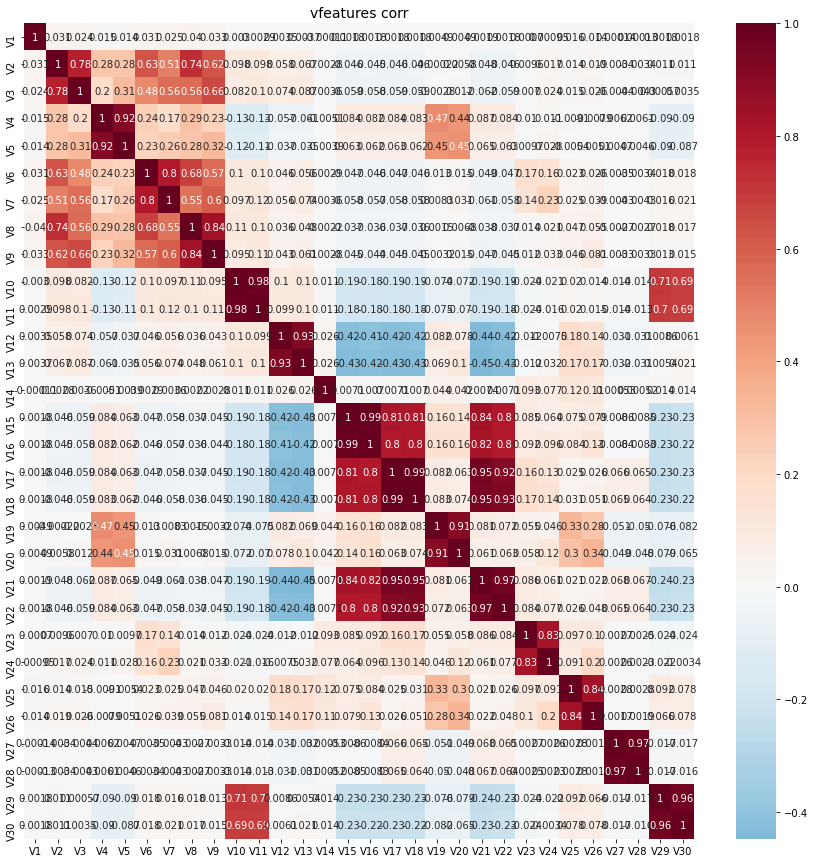

In [19]:
title = 'vfeatures corr'

def make_corr(vfeatures, title=''):
    cols = vfeatures[0:30]
    plt.figure(figsize=(15,15))
    sns.heatmap(df_train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if title!='': plt.title(title,fontsize=14)
    else: plt.title(vfeatures[0]+' - '+vfeatures[-1],fontsize=14)
    plt.show()
make_corr(vfeatures, title)

#### **PCA :**

In [0]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    
    return df

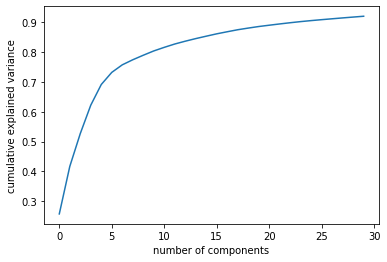

In [21]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

for col in vfeatures:
    df_train[col] = df_train[col].fillna((df_train[col].min() - 2))
    df_train[col] = (minmax_scale(df_train[col], feature_range=(0,1)))
    
df_train = PCA_change(df_train, vfeatures, prefix='PCA_V_', n_components=30)

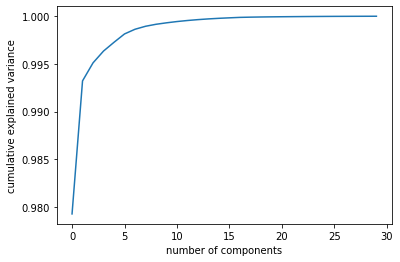

In [22]:
df_test = PCA_change(df_test, vfeatures, prefix='PCA_V_', n_components=30)

In [23]:
df_test.shape

(506691, 182)

In [24]:
df_train.shape

(590540, 183)

####**split data :**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [26]:
#### test -> val, stratified in train test split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_train.drop(labels=['isFraud', 'TransactionID','TransactionDT'], axis=1),
    df_train['isFraud'],
    stratify = df_train['isFraud'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_val.shape

((413378, 180), (177162, 180))

On utilise des méthodes de régularisation qui en ajoutant des pénalités sur les differents paramàtres des modèles de machine learning vont permettre de réduire les degrés de liberté du model et donc éviter le surapprentissage.





#### **1. Removing features with low variance :**

In [27]:
%%time
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = X_train
x_new =sel.fit_transform(X)

CPU times: user 7.33 s, sys: 1.44 s, total: 8.77 s
Wall time: 8.76 s


In [0]:
x_new2 = sel.fit_transform(X_val)

In [29]:
x_new.shape

(413378, 84)

In [30]:
x_new2.shape

(177162, 84)

In [0]:
X_train1 = x_new

In [0]:
X_val1 = x_new2

In [33]:
%%time

boost = XGBClassifier()
boost.fit(X_train1, y_train)

pred_train = boost.predict_proba(X_train1)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))

pred_test = boost.predict_proba(X_val1)
print("score auc test :",roc_auc_score(y_val, pred_test[:, 1]))

score auc train : 0.8887102271903561
score auc test : 0.8852374314410149
CPU times: user 1min 32s, sys: 153 ms, total: 1min 32s
Wall time: 1min 33s


In [34]:
## Random forest :
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 

rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_train1, y_train)

pred_train = rf.predict_proba(X_train1)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))


pred_val = rf.predict_proba(X_val1)
print("score auc test :",roc_auc_score(y_val, pred_val[:, 1]))

score auc train : 0.9999988299607883
score auc test : 0.9332168873917062
CPU times: user 1min 11s, sys: 61.8 ms, total: 1min 11s
Wall time: 1min 12s


#### **Tree-based feature selection :**

In [35]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
              

CPU times: user 1min 20s, sys: 1.58 s, total: 1min 22s
Wall time: 1min 22s


In [0]:
X_train2 = X_new
X_val2 = model.transform(X_val)

In [0]:
df_test2 = df_test.drop(labels=['TransactionID','TransactionDT'], axis=1)
df_test2 = model.transform(df_test2)

In [38]:
df_test2.shape

(506691, 67)

In [39]:
X_train2.shape

(413378, 67)

In [40]:
sample_submission

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


In [41]:
## XGboost :
%%time

boost = XGBClassifier()
boost.fit(X_train2, y_train)

pred_train = boost.predict_proba(X_train2)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))

pred_test = boost.predict_proba(X_val2)
print("score auc test :",roc_auc_score(y_val, pred_test[:, 1]))

score auc train : 0.8869665984824684
score auc test : 0.8848714679263474
CPU times: user 2min 8s, sys: 88.5 ms, total: 2min 8s
Wall time: 2min 8s


In [42]:
## Random forest :
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 

rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_train2, y_train)

pred_train = rf.predict_proba(X_train2)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))


pred_val = rf.predict_proba(X_val2)
print("score auc test :",roc_auc_score(y_val, pred_val[:, 1]))

score auc train : 0.9999999858749525
score auc test : 0.9159696216238655
CPU times: user 3min 4s, sys: 94.8 ms, total: 3min 5s
Wall time: 3min 5s


In [0]:
## KNN :
%%time
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train2, y_train)

pred_train = knn.predict_proba(X_train2)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))


pred_val = knn.predict_proba(X_val2)
print("score auc test :",roc_auc_score(y_val, pred_val[:, 1]))

score auc train : 0.9935263964423365
score auc test : 0.8125835171426843
CPU times: user 15min 49s, sys: 364 ms, total: 15min 49s
Wall time: 15min 49s


#LASSO

La méthode de lasso va nous permettre de mettre certaines features à 0 ce qui nous permettra de les enlever de notre modèles.

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [37]:
%%time
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver ='saga',max_iter=1000))
sel_.fit(scaler.transform(X_train), y_train)

CPU times: user 22min 37s, sys: 1.78 s, total: 22min 39s
Wall time: 22min 39s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [38]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 180
selected features: 176
features with coefficients shrank to zero: 4


In [39]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['dist2', 'M7_Miss', 'M8_Miss', 'M9_Miss'], dtype='object')

In [40]:
X_train_selected = sel_.transform(X_train)
X_val_selected = sel_.transform(X_val)
X_train_selected.shape, X_val_selected.shape

((413378, 176), (177162, 176))

In [42]:
## Random forest :
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 

rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_train_selected, y_train)

pred_train = rf.predict_proba(X_train_selected)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))


pred_val = rf.predict_proba(X_val_selected)
print("score auc test :",roc_auc_score(y_val, pred_val[:, 1]))


score auc train : 0.9999999978335816
score auc test : 0.9198544460343119
CPU times: user 2min 37s, sys: 113 ms, total: 2min 37s
Wall time: 2min 37s


# Elastic net

In [43]:
%%time
sel2_ = SelectFromModel(LogisticRegression(C=1, penalty = 'elasticnet', l1_ratio = 0.5, solver = 'saga', max_iter=1000 ))
sel2_.fit(scaler.transform(X_train), y_train)

CPU times: user 22min 39s, sys: 1.83 s, total: 22min 41s
Wall time: 22min 41s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [44]:
sel2_.get_support()

array([ True, False, False,  True, False, False,  True, False, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [45]:
# Test de significalité sur les coefs -> p-value 

selected2_feat = X_train.columns[(sel2_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected2_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel2_.estimator_.coef_ == 0)))

total features: 180
selected features: 49
features with coefficients shrank to zero: 1


In [46]:
removed2_feats = X_train.columns[(sel2_.estimator_.coef_ == 0).ravel().tolist()]
removed2_feats

Index(['dist2'], dtype='object')

In [47]:
X_train_selected2 = sel2_.transform(X_train)
X_val_selected2 = sel2_.transform(X_val)
X_train_selected2.shape, X_val_selected2.shape

((413378, 49), (177162, 49))

In [48]:
## Random forest :
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 

rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_train_selected2, y_train)

pred_train = rf.predict_proba(X_train_selected2)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))


pred_val = rf.predict_proba(X_val_selected2)
print("score auc test :",roc_auc_score(y_val, pred_val[:, 1]))

score auc train : 0.997289929128685
score auc test : 0.8927591333945702
CPU times: user 1min 59s, sys: 96.9 ms, total: 1min 59s
Wall time: 1min 59s
